# Начало лабораторной работы, юху(-оперативка в конце)

## Классификация

### Загрузка набора данных для задачи классификации

В данной лабораторной работе используется набор данных с классификацией некотрых персонажей вселенной Marvel

Набор данных состоит из 5 папок с изображениями 5 персонажей сооответственно: Капитан Омерика, Мертвый Бассейн, Соколиный Глаз, Халк, Росомаха

Ссылка на датасет: https://www.kaggle.com/datasets/codyfrederick/simple-marvel-characters?resource=download

#### Какова задача

Задача: классификация перечисленных персонажей вселенной Marvel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Устанавливаем seed для воспроизводимости
np.random.seed(42)

# Укажите путь к вашему датасету
dataset_path = "./static/images/data"

# Список классов (персонажей)
characters = os.listdir(dataset_path)
num_classes = len(characters)

print(f"Всего классов: {num_classes}")
print("Список персонажей:", characters)


Всего классов: 5
Список персонажей: ['captainamerica', 'deadpool', 'hawkeye', 'hulk', 'wolverine']


### Отображение данных

Вывод примеров классов

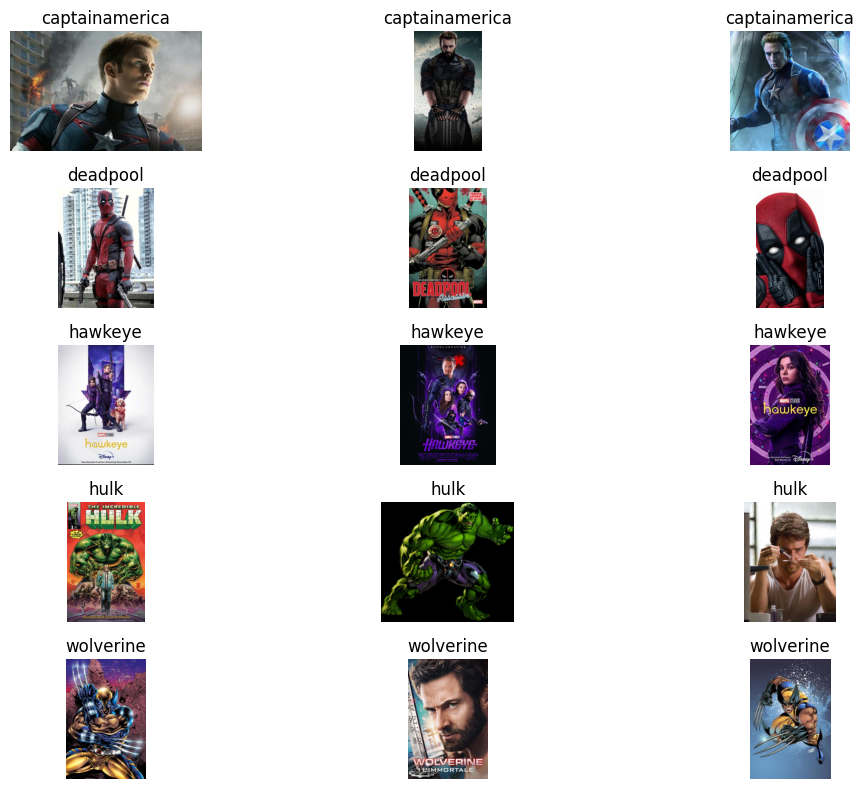

In [2]:
plt.figure(figsize=(12, 8))
for i, character in enumerate(characters[:5]):
    character_dir = os.path.join(dataset_path, character)
    img_files = os.listdir(character_dir)[:3]
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(character_dir, img_file)
        img = Image.open(img_path)
        
        plt.subplot(5, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(character)
        plt.axis('off')

plt.tight_layout()
plt.show()

### Предобработка изображений

* Конвертация в RGB на случай черно-белых изображений
* Ресайз до 128x128 пикселей
* Нормализация значений пикселей в диапазон [0, 1]
* Преобразование меток в one-hot encoding
* Разделение данных на выборки

In [10]:
# Путь к датасету
dataset_path = "./static/images/data"

# Получаем список персонажей
characters = sorted(os.listdir(dataset_path))
num_classes = len(characters)

# Параметры изображений
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)  # используем 2D-изображения для CNN

# Загрузка и предобработка изображений
X = []
y = []

for i, character in enumerate(characters):
    character_dir = os.path.join(dataset_path, character)
    for img_file in os.listdir(character_dir):
        try:
            img_path = os.path.join(character_dir, img_file)
            img = Image.open(img_path).convert('RGB')  # Убедимся, что 3 канала
            img = img.resize((img_width, img_height))
            img_array = np.array(img) / 255.0  # Нормализация
            X.append(img_array)
            y.append(i)
        except Exception as e:
            print(f"Ошибка при загрузке {img_path}: {e}")

X = np.array(X)
y = np.array(y)

# Преобразование меток в one-hot encoding
y = to_categorical(y, num_classes=num_classes)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество классов: {num_classes}")

Размер обучающей выборки: (215, 128, 128, 3)
Размер тестовой выборки: (54, 128, 128, 3)
Количество классов: 5


### Создание модели CNN

#### Архитектура CNN

Слои и их назначение:

1. Свёрточные блоки (Conv2D + BatchNorm + MaxPooling):

    * Выделяют пространственные признаки

    * BatchNorm ускоряет обучение

2. Dropout:

    * Борется с переобучением (0.2-0.5)

3. Полносвязные слои:

    * Анализируют извлечённые признаки

4. Выходной слой:

    * softmax для многоклассовой классификации


In [4]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Первый сверточный блок
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    # Второй сверточный блок
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Третий сверточный блок
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Полносвязные слои
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

model = create_cnn_model(input_shape, num_classes)
model.summary()

c:\Users\Admin\StudioProjects\AIM-PIbd-31-Alekseev-I-S\aimenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,679,973 (33.11 MB)

 Trainable params: 8,678,565 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Аугментация данных и обучение

Эффекты для аугментации:

* Повороты на ±20°

* Сдвиги по ширине/высоте на 20%

* Горизонтальное отражение

Для обучения возьмем 50 эпох

In [5]:
# Создаем генератор аугментированных данных
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор для тестовых данных (только нормализация)
test_datagen = ImageDataGenerator()

# Подготовка генераторов
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Коллбэки для обучения
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]

# Обучение модели
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


c:\Users\Admin\StudioProjects\AIM-PIbd-31-Alekseev-I-S\aimenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 683ms/step - accuracy: 0.2191 - loss: 2.8230 - val_accuracy: 0.2500 - val_loss: 1.6083 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2188 - loss: 2.1692 - val_accuracy: 0.1875 - val_loss: 1.6186 - learning_rate: 1.0000e-04
Epoch 3/50


c:\Users\Admin\StudioProjects\AIM-PIbd-31-Alekseev-I-S\aimenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.3167 - loss: 2.2168 - val_accuracy: 0.1875 - val_loss: 1.6216 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3125 - loss: 2.0393 - val_accuracy: 0.2812 - val_loss: 1.5984 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.4306 - loss: 2.0434 - val_accuracy: 0.2188 - val_loss: 1.7040 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5000 - loss: 1.6092 - val_accuracy: 0.2500 - val_loss: 1.6702 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - accuracy: 0.3554 - loss: 1.9729 - val_accuracy: 0.2188 - val_loss: 1.8088 - learning_rate: 1.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3043 - loss: 2.0110 - val_accuracy: 0.1875 - val_loss: 1.8583 - learning_rate: 1.0000e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.4436 - loss: 1.6193 - val_

### Оценка и визуализация результатов


Финальная точность на тестовых данных: 0.2407
Финальные потери на тестовых данных: 1.6688


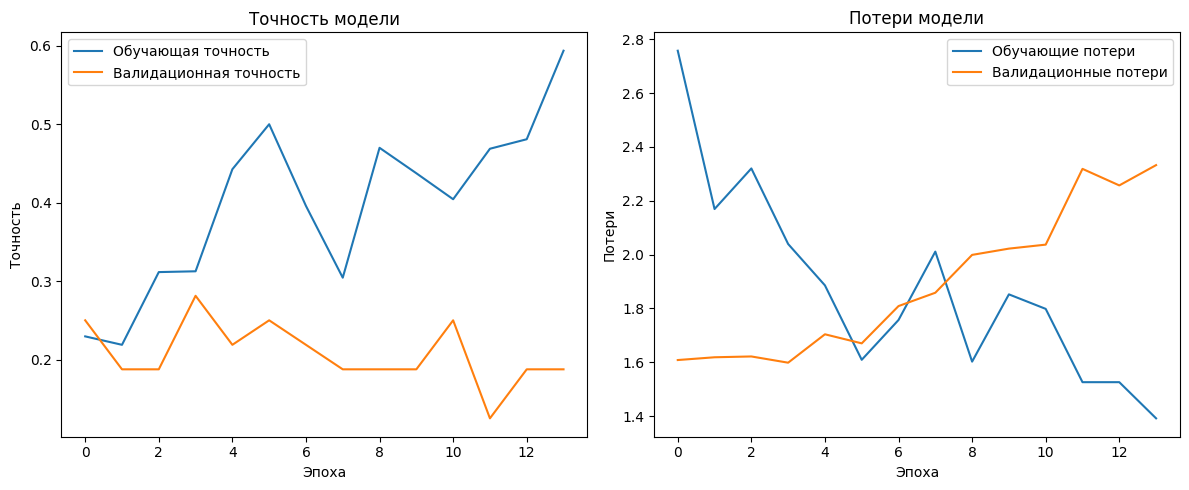

In [6]:
# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nФинальная точность на тестовых данных: {test_acc:.4f}")
print(f"Финальные потери на тестовых данных: {test_loss:.4f}")

# Графики обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающие потери')
plt.plot(history.history['val_loss'], label='Валидационные потери')
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()

plt.tight_layout()
plt.show()

Реузльтаты обученной модели оказались не самыми лучшими - 18.5% точности.

Анализ проблемы:

1. Недостаточная сложность модели для датасета

    Так как в кадом классе датасета персонаж предосталвен во всех возможных вариациях(в супер-костюме - без костюма, в полный рост - в анфаз и т.д.), модели достаточно тяжело кооректно предугадать персонажа по изборажению

2. Переобучение

    Слишком большая разница между train и val accuracy

3. Проблемы с данными 

    Неправильная предобработка или несбалансированные классы

### Попытка №2

На основе недочетов прошлой модели попробуем создать новую, более подходящую для решения поставленной задачи

#### Ключевые улучшения:

1. Увеличенная емкость модели:

    * Добавлено больше фильтров (64 → 128 → 256)

    * Увеличен размер полносвязного слоя (512 нейронов)

2. Улучшенная регуляризация:

    * Добавлен L2-регуляризатор для всех слоев

    * Увеличен Dropout (до 0.6 в последнем слое)

    * Более агрессивная аугментация данных

3. Оптимизация обучения:

    * Уменьшена скорость обучения с целью рассмотрения наибольшего количества минимумов - learning rate (0.00001)

    * Добавлено сохранение лучшей модели

    * Увеличен patience для EarlyStopping

4. Работа с дисбалансом классов:

    * Добавлена визуализация распределения классов

    * Реализовано автоматическое взвешивание классов

5. Дополнительные улучшения:

    * Вертикальное отражение в аугментации

    * Регулировка яркости изображений

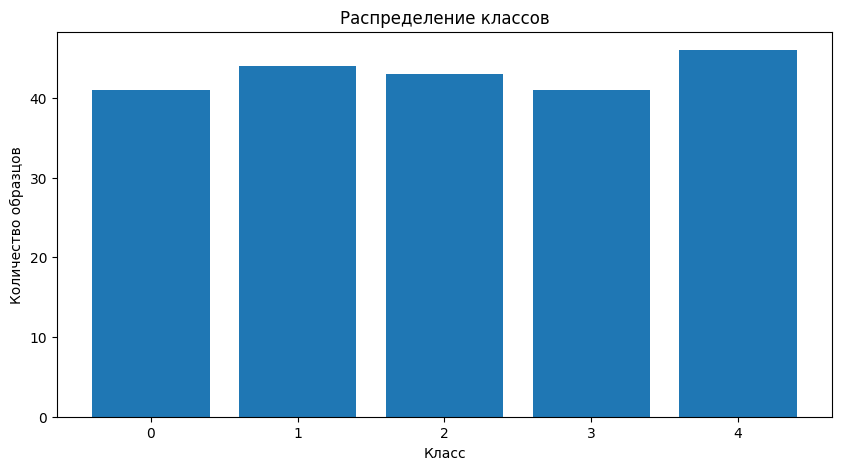

Количество образцов в классах: [41. 44. 43. 41. 46.]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 34,708,549 (132.40 MB)

 Trainable params: 34,705,733 (132.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2254 - loss: 3.7768

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2229 - loss: 3.7817 - val_accuracy: 0.1875 - val_loss: 2.8892 - learning_rate: 1.0000e-05
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2188 - loss: 4.6368

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.2188 - loss: 4.6368 - val_accuracy: 0.2500 - val_loss: 2.8868 - learning_rate: 1.0000e-05
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2511 - loss: 3.7162 - val_accuracy: 0.2188 - val_loss: 2.8898 - learning_rate: 1.0000e-05
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1739 - loss: 3.7196 - val_accuracy: 0.1562 - val_loss: 2.8895 - learning_rate: 1.0000e-05
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2405 - loss: 3.8828 - val_accuracy: 0.1875 - val_loss: 2.8862 - learning_rate: 1.0000e-05
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.3125 - loss: 4.1274 - val_accuracy: 0.1875 - val_loss: 2.8843 - learning_rate: 1.0000e-05
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2315 - loss: 3.7674 - val_accuracy: 0.1875 - val_loss: 2.9007 - learning_rate: 1.0000e-05
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.0870 - loss: 3.9548 - val_accura

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.3438 - loss: 2.7935 - val_accuracy: 0.2812 - val_loss: 2.8882 - learning_rate: 1.0000e-05
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1864 - loss: 3.8101 - val_accuracy: 0.2188 - val_loss: 2.8858 - learning_rate: 1.0000e-05
Epoch 16/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2500 - loss: 3.4220

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.2500 - loss: 3.4220 - val_accuracy: 0.3125 - val_loss: 2.8826 - learning_rate: 1.0000e-05
Epoch 17/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2332 - loss: 3.6672 - val_accuracy: 0.2500 - val_loss: 2.8784 - learning_rate: 1.0000e-05
Epoch 18/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.1875 - loss: 4.1298 - val_accuracy: 0.2188 - val_loss: 2.8824 - learning_rate: 1.0000e-05
Epoch 19/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.2367 - loss: 3.9492 - val_accuracy: 0.2812 - val_loss: 2.8750 - learning_rate: 1.0000e-05
Epoch 20/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1875 - loss: 3.4662 - val_accuracy: 0.2188 - val_loss: 2.9051 - learning_rate: 1.0000e-05
Epoch 21/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1641 - loss: 4.0261 - val_accuracy: 0.2812 - val_loss: 2.8953 - learning_rate: 1.0000e-05
Epoch 22/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.2188 - loss: 3.5259 - val_

ValueError: File not found: filepath=best_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Улучшенная архитектура модели
def create_improved_model(input_shape, num_classes):
    model = Sequential([
        # Увеличение количества фильтров и добавление L2 регуляризации
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    
    # Измененный оптимизатор с более низким learning rate
    optimizer = Adam(learning_rate=0.00001)
    
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Улучшенная аугментация данных
def create_datagen():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest'
    )

# Улучшенные callback-функции
def create_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7),
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
    ]

# Проверка баланса классов
def check_class_balance(y):
    class_counts = np.sum(y, axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_counts)), class_counts)
    plt.title('Распределение классов')
    plt.xlabel('Класс')
    plt.ylabel('Количество образцов')
    plt.show()
    return class_counts

# Проверяем баланс классов
class_counts = check_class_balance(y_train)
print("Количество образцов в классах:", class_counts)

# Если классы несбалансированы, добавляем взвешивание классов
class_weights = {i: 1./class_counts[i] for i in range(num_classes)}

# Создаем и обучаем модель
model = create_improved_model(input_shape, num_classes)
model.summary()

train_datagen = create_datagen()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,
    callbacks=create_callbacks(),
    class_weight=class_weights if min(class_counts) < max(class_counts) * 0.7 else None,
    verbose=1
)

from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(test_generator, verbose=0)
print(f"\nЛучшая точность на тестовых данных: {test_acc:.4f}")
print(f"Лучшие потери на тестовых данных: {test_loss:.4f}")

### Оценим проделанную работу

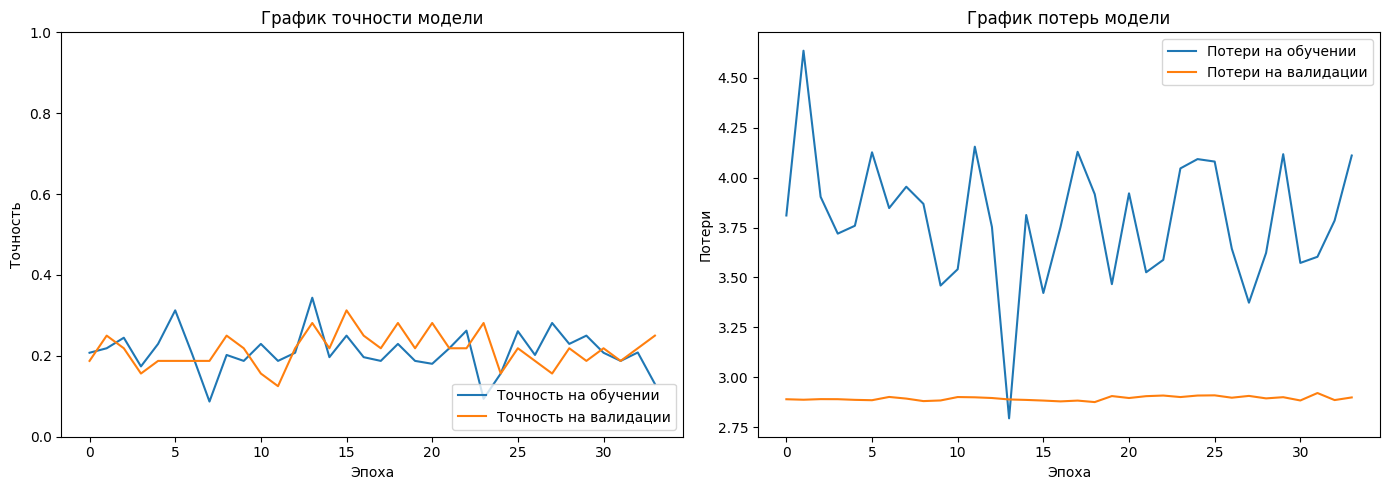


Финальная точность на обучении: 0.1304
Финальная точность на валидации: 0.2500


<Figure size 640x480 with 0 Axes>

In [9]:
# Визуализация результатов обучения
plt.figure(figsize=(14, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('График точности модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.ylim([0, 1])  # Ограничиваем ось Y от 0 до 1 для точности
plt.legend(loc='lower right')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('График потерь модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Дополнительная информация
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nФинальная точность на обучении: {final_train_acc:.4f}")
print(f"Финальная точность на валидации: {final_val_acc:.4f}")

# Сохранение графиков
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

Модель эффективнее распознает персонажей, но всё еще не с самой высокой точностью. В качестве причин таких результатов можно указать одну из описанных ранее(1-ю причину в блоке описания причин полученных результатов у прошлой модели) и достаточно агрессивную регуляризацию